In [1]:
import scanpy as sc
import re
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt

Example classifier to distinguish two cell subsets
==

Workflow:
- take a single cell RNAseq dataset (PBMCs)
- aim to classify between CD4 T cells and CD8 T cells. We will ignore all other cells

For this, we will:
- subset the data to only cells that are either CD4 or CD8
- annotate each cell with its class (label 0 will be for CD4 cells, and label 1 will be for CD8 cells)
- our input data X will be the gene expression profile for each cell (cells x genes)
- our output or label y will be the 0/1 labels for the cells (cells x 2)
- split X and y into training and test sets. We will use the training set to train the model, and the test set to measure the performance of the model
- train a logistic regression classifier on the training data, which will predict 0 for cells that are CD4 and 1 for cells that are CD8.
- measure the performance of the model
- once we have confirmed that the model performs well, we can identify which genes are important for the model's predictions. The genes with the highest coefficients are most predictive of label 1 (CD8 cells), and the genes with the most negative coefficients are most predictive of label 0 (CD4)

In [ ]:


#using sklearn https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [4]:
adata=sc.datasets.pbmc68k_reduced()

In [5]:
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [7]:
set(adata.obs['louvain'])

{'0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9'}

/gstore/data/ctgbioinfo/ursuo/software/anaconda/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/gstore/data/ctgbioinfo/ursuo/software/anaconda/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gstore/data/ctgbioinfo/ursuo/software/anaconda/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


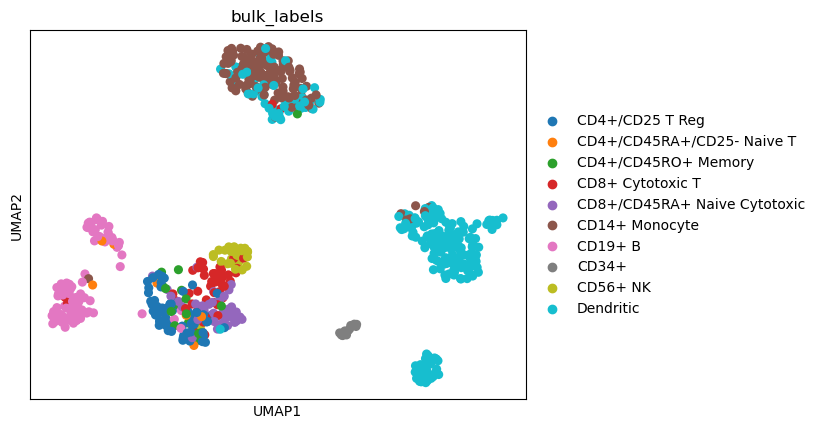

In [10]:
sc.pl.umap(adata,color='bulk_labels')

In [11]:
set(adata.obs['bulk_labels'])

{'CD14+ Monocyte',
 'CD19+ B',
 'CD34+',
 'CD4+/CD25 T Reg',
 'CD4+/CD45RA+/CD25- Naive T',
 'CD4+/CD45RO+ Memory',
 'CD56+ NK',
 'CD8+ Cytotoxic T',
 'CD8+/CD45RA+ Naive Cytotoxic',
 'Dendritic'}

In [15]:
#say i want to distinguish between all CD4 vs all CD8 cells
LABELNAME='bulk_labels'

label_0=['CD4+/CD25 T Reg',
 'CD4+/CD45RA+/CD25- Naive T',
 'CD4+/CD45RO+ Memory']
label_1=['CD8+ Cytotoxic T',
 'CD8+/CD45RA+ Naive Cytotoxic']
keep_cells=[]

new_label=[]
for i in range(adata.n_obs):
    current_label=adata.obs[LABELNAME][i]
    current_cell=adata.obs_names[i]
    if current_label in label_0:
        new_label.append(0)
        keep_cells.append(current_cell)
    elif current_label in label_1:
        new_label.append(1)
        keep_cells.append(current_cell)

#keep only the cells in our categories of interest
adata_subset=adata[keep_cells,:]
adata_subset.obs['new_label']=new_label
adata_subset



/local/16229240/ipykernel_4289/37166943.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_label=adata.obs[LABELNAME][i]
/gstore/data/ctgbioinfo/ursuo/software/anaconda/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/local/16229240/ipykernel_4289/37166943.py:24: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs['new_label']=new_label


AnnData object with n_obs × n_vars = 192 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain', 'new_label'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [16]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#input data: cells x genes (expression)
X=adata_subset.X
#labels: 0 if CD4, 1 if CD8
y=adata_subset.obs['new_label']

#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

#train the classifier
clf = LogisticRegression(random_state=0).fit(X_train, y_train)


/gstore/data/ctgbioinfo/ursuo/software/anaconda/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/gstore/data/ctgbioinfo/ursuo/software/anaconda/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [17]:
clf

LogisticRegression(random_state=0)

In [ ]:
#measure the performance of the model

In [33]:
#1. how well does it classify the test set?
y_test_pred=clf.predict_proba(X_test)[:,1] #these are the predictions for being in class 1 for the cells in the test set
y_true=y_test

#we can compute accuracy by asking how many times we were correct (predicting >0.5 for cells with label 1,
#and predicting <0.5 for cells with label 0)
agreement=1.0*(y_true==(y_test_pred>=0.5))
print(agreement)

print('======')
print('Agree for',agreement.sum(),'out of',agreement.shape[0], "so",100.0*agreement.sum()/agreement.shape[0],'% of the time')

index
TGGAAAGATGGCAT-2    0.0
TGTCAGGATGGTGT-6    0.0
TGCGTAGACTGTGA-3    0.0
ATGTTAGAAGCGGA-7    1.0
GCAAACTGCATCAG-5    1.0
                   ... 
GGGATGGAATGCCA-2    1.0
TAATGAACATGACC-7    1.0
TAGCCCTGGAGGAC-8    1.0
GGGATGGATTCCAT-8    1.0
TACGCGCTCGCTAA-4    1.0
Name: new_label, Length: 64, dtype: float64
Agree for 54.0 out of 64 so 84.375 % of the time


/gstore/data/ctgbioinfo/ursuo/software/anaconda/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/gstore/data/ctgbioinfo/ursuo/software/anaconda/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/gstore/data/ctgbioinfo/ursuo/software/anaconda/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/gstore/data/ctgbioinfo/ursuo/software/anaconda/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarni

Text(0, 0.5, 'Recall')

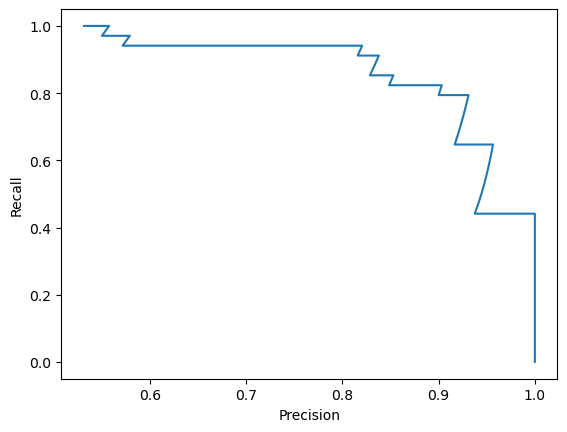

In [34]:
#we can also quantify the performance of the model by plotting the precision recall curve
from sklearn.metrics import precision_recall_curve
y_test_pred=clf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve( y_test, y_test_pred)
plt.plot(precision,recall)
plt.xlabel('Precision')
plt.ylabel('Recall')

In [41]:
#finally, we can ask which genes were important for the prediction
coefficients=pd.DataFrame({'coefficient':clf.coef_[0]},index=list(adata_subset.var_names))
coefficients

,coefficient
HES4,0.009543
TNFRSF4,-0.051003
SSU72,0.097059
PARK7,0.075881
RBP7,0.007304
...,...
SUMO3,-0.023481
ITGB2,-0.022986
S100B,0.128600
PRMT2,0.090763


In [49]:
#we can sort for the coefficients with the highest magnitude coefficients

#as expected, CD8 shows up as predictive of label 1 (CD8 cells)
coefficients.sort_values(by='coefficient',ascending=False).head(10)

,coefficient
CD8B,0.346976
CD8A,0.305216
DDX5,0.217876
CCL5,0.206830
NSRP1,0.205763
RP11-291B21.2,0.204162
GNLY,0.196255
HSD17B11,0.192993
ANAPC16,0.191195
CHCHD7,0.187175


In [50]:
#as expected, CD8 shows up as predictive of label 0 (CD4 cells), i.e. has a negative coefficient 
coefficients.sort_values(by='coefficient',ascending=True).head(10)

,coefficient
CWC25,-0.197274
CD40LG,-0.192238
CRIP1,-0.190177
SKP1,-0.182101
CORO1B,-0.155572
CAPN2,-0.155378
CD4,-0.151801
TRAF3IP3,-0.147172
MZT2B,-0.146466
CCT3,-0.144193
